In [1]:
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('twitter.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
890288,4,1688007545,Sun May 03 10:07:12 PDT 2009,NO_QUERY,Techno_Barista,Good morning tweeple! Heading off to the books...
709201,0,2257541967,Sat Jun 20 14:30:09 PDT 2009,NO_QUERY,SweetSin2Men,So like twitter is not letting me upload a pic...
26112,0,1558611860,Sun Apr 19 08:53:57 PDT 2009,NO_QUERY,Dreamyeyes,"http://twitpic.com/3lksu - More or less, still..."
978686,4,1833859605,Mon May 18 00:42:54 PDT 2009,NO_QUERY,jessicastrust,@YourMrBumbles @Teelou Thank you for #maternal...
671368,0,2246843820,Fri Jun 19 18:12:26 PDT 2009,NO_QUERY,kvalentina,@eryittam What's wrong?


In [3]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [5]:
print('length of data is', len(df))

length of data is 1600000


In [6]:
df. shape

(1600000, 6)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [9]:
np.sum(df.isnull().any(axis=1))

0

In [10]:
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Count of columns in the data is:   6
Count of rows in the data is:   1600000


In [11]:
df['target'].unique()

array([0, 4], dtype=int64)

In [13]:
df['target'].nunique()

2

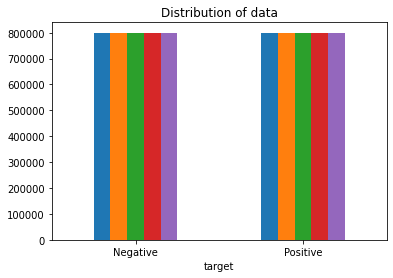

In [14]:
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])

<AxesSubplot:xlabel='target', ylabel='count'>

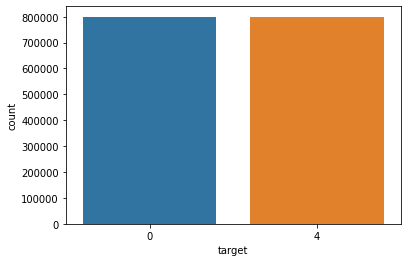

In [15]:
import seaborn as sns
sns.countplot(x='target', data=df)

In [16]:
data=df[['text','target']]

In [17]:
data['target'] = data['target'].replace(4,1)

C:\Users\srini\AppData\Local\Temp\ipykernel_3660\2499609609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


In [18]:
data['target'].unique()

array([0, 1], dtype=int64)

In [19]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [20]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [21]:
dataset = pd.concat([data_pos, data_neg])

In [22]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

19995    not much time off this weekend, work trip to m...
19996                            one more day of holidays 
19997    feeling so down right now .. i hate you damn h...
19998    geez,i hv to read the whole book of personalit...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [23]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

19995    not much time off this weekend work trip to ma...
19996                            one more day of holidays 
19997    feeling so down right now  i hate you damn hum...
19998    geezi hv to read the whole book of personality...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [24]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

19995    not much time off this weekend work trip to ma...
19996                            one more day of holidays 
19997    feeling so down right now  i hate you damn hum...
19998    geezi hv to read the whole book of personality...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [25]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

19995    not much time off this weekend work trip to ma...
19996                            one more day of holidays 
19997    feeling so down right now  i hate you damn hum...
19998    geezi hv to read the whole book of personality...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [26]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

19995    not much time off this weekend work trip to ma...
19996                            one more day of holidays 
19997    feeling so down right now  i hate you damn hum...
19998    geezi hv to read the whole book of personality...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [27]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

800000              []
800001          [w, w]
800002    [w, w, w, w]
800003             [w]
800004              []
Name: text, dtype: object

In [28]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000              []
800001          [w, w]
800002    [w, w, w, w]
800003             [w]
800004              []
Name: text, dtype: object

In [29]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

LookupError: 
**********************************************************************
  Resource [93mwordnet[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('wordnet')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/wordnet[0m

  Searched in:
    - 'C:\\Users\\srini/nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\\nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\\share\\nltk_data'
    - 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\\lib\\nltk_data'
    - 'C:\\Users\\srini\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [30]:
X=data.text
y=data.target

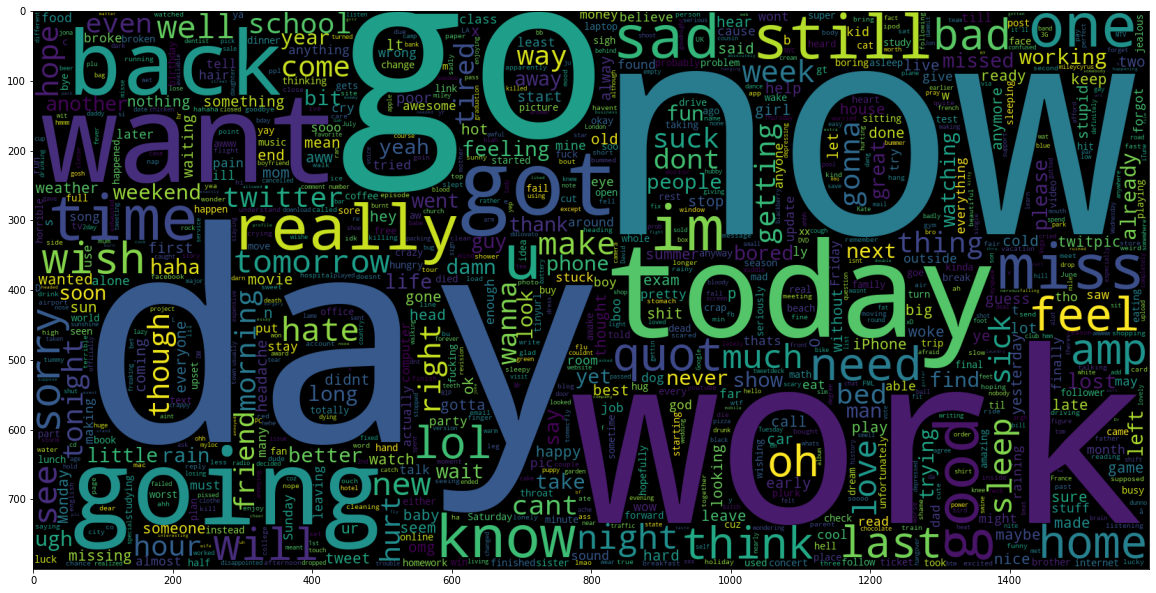

In [31]:
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

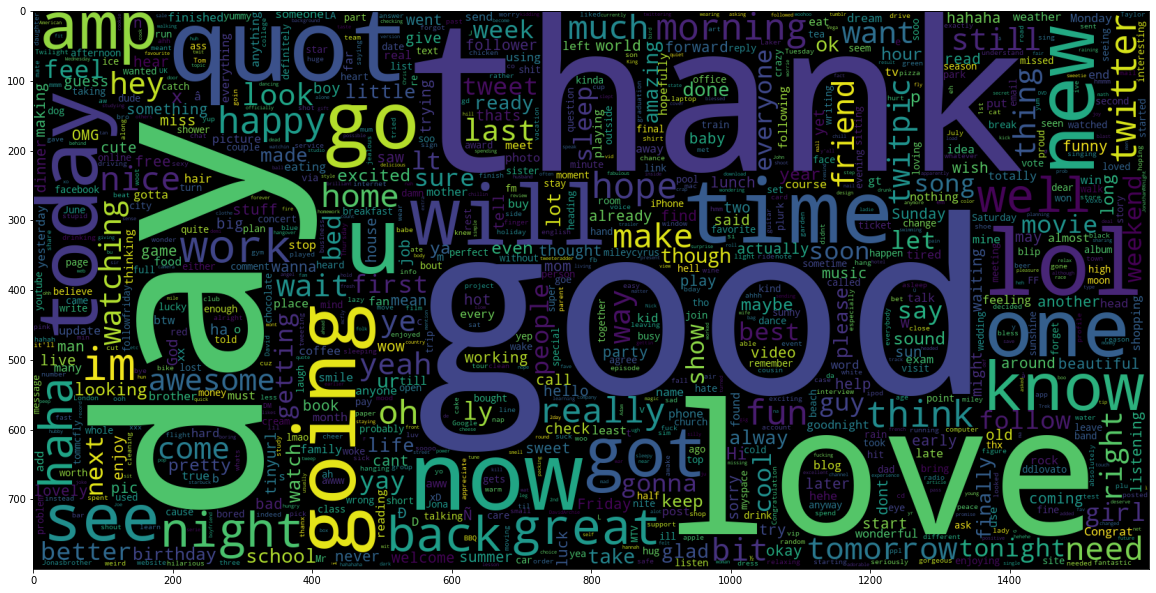

In [32]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)


In [34]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names'

In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [ ]:
def model_Evaluate(model):
# Predict values for Test dataset
y_pred = model.predict(X_test)
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))
# Compute and plot the Confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
categories = ['Negative','Positive']
group_names = ['True Neg','False Pos', 'False Neg','True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
xticklabels = categories, yticklabels = categories)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [35]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

ValueError: could not convert string to float: "@PanicCrew still no michigan shows    where's the love??"

In [36]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

NameError: name 'y_pred1' is not defined

In [37]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

ValueError: could not convert string to float: "@PanicCrew still no michigan shows    where's the love??"

In [38]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

NameError: name 'y_pred2' is not defined